In [106]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

sys.path.append("..")
from src.nce.cd_cnce import CdCnceCrit
from src.nce.cd_mh_cnce import CdMHCnceCrit
from src.nce.per_cnce import PersistentCondNceCrit
from src.nce.per_cnce_batch import PersistentCondNceCritBatch
from src.nce.per_cnce_batch import PersistentCondNceCritBatch
from src.nce.per_mh_cnce_batch import PersistentMHCnceCritBatch

from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_stopping, remove_file

from src.experiments.ring_model_exp_utils import generate_true_params, initialise_params
from src.experiments.noise_distr_utils import get_nce_noise_distr_par, get_cnce_noise_distr_par

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EXPERIMENTS

In [107]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = 200
num_neg_samples = [5]
reps = 100

# Training specs
batch_size = 20
num_epochs = 50
base_lr = 0.01
lr = base_lr * batch_size ** 0.5
lr_factor = 0.1

In [108]:
# Configurations to consider in experiments 

config_cnce = {
    "criterion": CdCnceCrit,
    "label": "cd_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 1,
    "calc_acc_prob": True
}

config_cd_mh = {
    "criterion": CdMHCnceCrit,
    "label": "cd_mh",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 1,
    "calc_acc_prob": True
}

config_pers_cnce = {
    "criterion": PersistentCondNceCrit,
    "label": "pers_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
}

config_pers_cnce_batch = {
    "criterion": PersistentCondNceCritBatch,
    "label": "pers_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
    "calc_acc_prob": True
}

config_pers_mh_cnce_batch = {
    "criterion": PersistentMHCnceCritBatch,
    "label": "pers_mh_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
    "calc_acc_prob": True
}

configs = [config_cnce, config_pers_cnce_batch, config_cd_mh, config_pers_mh_cnce_batch]

In [109]:
def get_simple_cnce_noise_distr_par(y):
    epsilon = torch.std(y, dim=-1).mean()

    return torch.eye(y.shape[-1]) * epsilon ** 2

In [110]:
# Run experiments

# Data saved over reps
error_res = np.zeros((len(num_neg_samples), len(configs), int(np.ceil(num_samples / batch_size) * num_epochs), reps))
acc_prob_res = np.zeros((len(num_neg_samples), len(configs), 2, int(np.ceil(num_samples / batch_size) * num_epochs), reps))
acc_prob_res_pers = np.zeros((len(num_neg_samples), len(configs), 2, int(np.ceil(num_samples / batch_size) * num_epochs), reps))

for i, J in enumerate(num_neg_samples):
    for rep in range(reps):

        # Get data 
        mu, precision, _ = generate_true_params()
        error_metric = PrecisionErrorMetric(true_precision=precision).metric            

        training_data = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                                         root_dir="res/datasets/ring_data_size_" + str(num_samples) + "_nn_" + str(J) + "_rep_" + str(rep))
        train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

        # Initialise           
        _, log_precision_init, log_z_init = initialise_params()

        # Get noise distr. params
        p_m = RingModel(mu=mu, log_precision=log_precision_init.clone())
        cov_noise_cnce = get_simple_cnce_noise_distr_par(training_data.get_full_data()) #get_cnce_noise_distr_par(training_data.get_full_data(), J, p_m)

        for j, config in enumerate(configs):

            # Remove old acc. prob.
            remove_file("res/" + config["label"] + "_num_neg_" + str(J) + "_cd_cnce_acc_prob.npy")
            remove_file("res/" + config["label"] + "_num_neg_" + str(J) + "_cd_mh_acc_prob.npy")

            # Make sure that these are "reinitialised"
            p_m, p_n, criterion = None, None, None

            if config["estimate_part_fn"]:
                p_m = RingModelNCE(mu=mu, log_precision=log_precision_init.clone(), log_part_fn=log_z_init.clone())
            else:
                p_m = RingModel(mu=mu, log_precision=log_precision_init.clone())

            p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
            
            if config["mcmc_steps"] is not None: 
                criterion = config["criterion"](p_m, p_n, J, config["mcmc_steps"], save_acc_prob=config["calc_acc_prob"])
            else:
                criterion = config["criterion"](p_m, p_n, J, save_acc_prob=config["calc_acc_prob"])

            save_dir_pre = "res/" + config["label"] + "_num_neg_" + str(num_neg_samples[i])
            _ = train_model(criterion, error_metric, train_loader, save_dir_pre + "_error", num_epochs=num_epochs,
                            stopping_condition=no_stopping, lr=lr, decaying_lr=True, lr_factor=lr_factor)

            # Fetch data that has been saved
            error_res[i, j, :, rep] = np.load(save_dir_pre + "_error.npy")
            if config["calc_acc_prob"]:
                acc_prob_res[i, j, 0, :, rep] = np.load(save_dir_pre + "_" + "cd_cnce" + "_acc_prob.npy").mean(axis=0)
                acc_prob_res[i, j, 1, :, rep] = np.load(save_dir_pre + "_" + "cd_mh" + "_acc_prob.npy").mean(axis=0)
                acc_prob_res_pers[i, j, 0, :, rep] = np.load(save_dir_pre + "_" + "cd_cnce" + "_acc_prob.npy").mean(axis=0)
                acc_prob_res_pers[i, j, 1, :, rep] = np.load(save_dir_pre + "_" + "cd_mh" + "_acc_prob.npy").mean(axis=0)

# Save res
np.save("res/final_param_error_cnce_exp_w_pers_num_samples_" + str(num_samples) + "_test", error_res)
np.save("res/final_acc_prob_cnce_exp_w_pers_num_samples_" + str(num_samples) + "_test", acc_prob_res)
np.save("res/final_acc_prob_pers_cnce_exp_w_pers_num_samples_" + str(num_samples) + "_test", acc_prob_res_pers)

[10] evaluation metric: 0.024
[20] evaluation metric: 0.007
[30] evaluation metric: 0.029
[40] evaluation metric: 0.045
[50] evaluation metric: 0.052
Finished training
Data saved
[10] evaluation metric: 0.014
[20] evaluation metric: 0.059
[30] evaluation metric: 0.038
[40] evaluation metric: 0.024
[50] evaluation metric: 0.018
Finished training
Data saved
[10] evaluation metric: 0.021
[20] evaluation metric: 0.005
[30] evaluation metric: 0.029
[40] evaluation metric: 0.045
[50] evaluation metric: 0.057
Finished training
Data saved
[10] evaluation metric: 0.012
[20] evaluation metric: 0.005
[30] evaluation metric: 0.016
[40] evaluation metric: 0.034
[50] evaluation metric: 0.030
Finished training
Data saved
[10] evaluation metric: 0.009
[20] evaluation metric: 0.037
[30] evaluation metric: 0.056
[40] evaluation metric: 0.066
[50] evaluation metric: 0.070
Finished training
Data saved
[10] evaluation metric: 0.002
[20] evaluation metric: 0.000
[30] evaluation metric: 0.000
[40] evaluation

[10] evaluation metric: 0.003
[20] evaluation metric: 0.001
[30] evaluation metric: 0.000
[40] evaluation metric: 0.000
[50] evaluation metric: 0.000
Finished training
Data saved
[10] evaluation metric: 0.022
[20] evaluation metric: 0.051
[30] evaluation metric: 0.056
[40] evaluation metric: 0.060
[50] evaluation metric: 0.043
Finished training
Data saved
[10] evaluation metric: 78.541
[20] evaluation metric: 69.692
[30] evaluation metric: 63.076
[40] evaluation metric: 58.645
[50] evaluation metric: 56.371
Finished training
Data saved
[10] evaluation metric: 9.422
[20] evaluation metric: 0.867
[30] evaluation metric: 0.445
[40] evaluation metric: 0.041
[50] evaluation metric: 0.022
Finished training
Data saved
[10] evaluation metric: 75.279
[20] evaluation metric: 64.439
[30] evaluation metric: 56.211
[40] evaluation metric: 50.843
[50] evaluation metric: 48.143
Finished training
Data saved
[10] evaluation metric: 9.958
[20] evaluation metric: 0.037
[30] evaluation metric: 0.434
[40] 

[50] evaluation metric: 0.099
Finished training
Data saved
[10] evaluation metric: 0.125
[20] evaluation metric: 0.020
[30] evaluation metric: 0.004
[40] evaluation metric: 0.001
[50] evaluation metric: 0.000
Finished training
Data saved
[10] evaluation metric: 0.114
[20] evaluation metric: 0.141
[30] evaluation metric: 0.130
[40] evaluation metric: 0.139
[50] evaluation metric: 0.146
Finished training
Data saved
[10] evaluation metric: 0.114
[20] evaluation metric: 0.011
[30] evaluation metric: 0.002
[40] evaluation metric: 0.000
[50] evaluation metric: 0.000
Finished training
Data saved
[10] evaluation metric: 0.106
[20] evaluation metric: 0.093
[30] evaluation metric: 0.099
[40] evaluation metric: 0.120
[50] evaluation metric: 0.144
Finished training
Data saved
[10] evaluation metric: 0.319
[20] evaluation metric: 0.216
[30] evaluation metric: 0.162
[40] evaluation metric: 0.130
[50] evaluation metric: 0.118
Finished training
Data saved
[10] evaluation metric: 0.012
[20] evaluation 

[40] evaluation metric: 0.018
[50] evaluation metric: 0.021
Finished training
Data saved
[10] evaluation metric: 0.137
[20] evaluation metric: 0.031
[30] evaluation metric: 0.012
[40] evaluation metric: 0.006
[50] evaluation metric: 0.004
Finished training
Data saved
[10] evaluation metric: 0.018
[20] evaluation metric: 0.007
[30] evaluation metric: 0.025
[40] evaluation metric: 0.020
[50] evaluation metric: 0.022
Finished training
Data saved
[10] evaluation metric: 0.503
[20] evaluation metric: 0.230
[30] evaluation metric: 0.132
[40] evaluation metric: 0.097
[50] evaluation metric: 0.082
Finished training
Data saved
[10] evaluation metric: 0.073
[20] evaluation metric: 0.031
[30] evaluation metric: 0.056
[40] evaluation metric: 0.069
[50] evaluation metric: 0.050
Finished training
Data saved
[10] evaluation metric: 0.352
[20] evaluation metric: 0.156
[30] evaluation metric: 0.087
[40] evaluation metric: 0.057
[50] evaluation metric: 0.043
Finished training
Data saved
[10] evaluation 

[20] evaluation metric: 0.049
[30] evaluation metric: 0.052
[40] evaluation metric: 0.051
[50] evaluation metric: 0.058
Finished training
Data saved
[10] evaluation metric: 7.954
[20] evaluation metric: 2.753
[30] evaluation metric: 1.609
[40] evaluation metric: 1.047
[50] evaluation metric: 0.865
Finished training
Data saved
[10] evaluation metric: 0.084
[20] evaluation metric: 0.138
[30] evaluation metric: 0.046
[40] evaluation metric: 0.042
[50] evaluation metric: 0.025
Finished training
Data saved
[10] evaluation metric: 6.969
[20] evaluation metric: 2.775
[30] evaluation metric: 1.174
[40] evaluation metric: 0.774
[50] evaluation metric: 0.635
Finished training
Data saved
[10] evaluation metric: 0.067
[20] evaluation metric: 0.060
[30] evaluation metric: 0.066
[40] evaluation metric: 0.044
[50] evaluation metric: 0.043
Finished training
Data saved
[10] evaluation metric: 0.217
[20] evaluation metric: 0.013
[30] evaluation metric: 0.000
[40] evaluation metric: 0.001
[50] evaluation

[10] evaluation metric: 0.024
[20] evaluation metric: 0.018
[30] evaluation metric: 0.021
[40] evaluation metric: 0.025
[50] evaluation metric: 0.029
Finished training
Data saved
[10] evaluation metric: 0.330
[20] evaluation metric: 0.032
[30] evaluation metric: 0.006
[40] evaluation metric: 0.001
[50] evaluation metric: 0.000
Finished training
Data saved
[10] evaluation metric: 0.024
[20] evaluation metric: 0.026
[30] evaluation metric: 0.031
[40] evaluation metric: 0.023
[50] evaluation metric: 0.029
Finished training
Data saved
[10] evaluation metric: 0.005
[20] evaluation metric: 0.014
[30] evaluation metric: 0.020
[40] evaluation metric: 0.025
[50] evaluation metric: 0.028
Finished training
Data saved
[10] evaluation metric: 0.004
[20] evaluation metric: 0.014
[30] evaluation metric: 0.008
[40] evaluation metric: 0.005
[50] evaluation metric: 0.005
Finished training
Data saved
[10] evaluation metric: 0.005
[20] evaluation metric: 0.019
[30] evaluation metric: 0.026
[40] evaluation

[50] evaluation metric: 6.071
Finished training
Data saved
[10] evaluation metric: 1.353
[20] evaluation metric: 0.180
[30] evaluation metric: 0.211
[40] evaluation metric: 0.400
[50] evaluation metric: 0.585
Finished training
Data saved
[10] evaluation metric: 0.179
[20] evaluation metric: 0.101
[30] evaluation metric: 0.063
[40] evaluation metric: 0.046
[50] evaluation metric: 0.038
Finished training
Data saved
[10] evaluation metric: 0.127
[20] evaluation metric: 0.139
[30] evaluation metric: 0.129
[40] evaluation metric: 0.077
[50] evaluation metric: 0.092
Finished training
Data saved
[10] evaluation metric: 0.148
[20] evaluation metric: 0.065
[30] evaluation metric: 0.042
[40] evaluation metric: 0.032
[50] evaluation metric: 0.028
Finished training
Data saved
[10] evaluation metric: 0.112
[20] evaluation metric: 0.059
[30] evaluation metric: 0.109
[40] evaluation metric: 0.171
[50] evaluation metric: 0.170
Finished training
Data saved
[10] evaluation metric: 2.630
[20] evaluation 

[40] evaluation metric: 0.003
[50] evaluation metric: 0.003
Finished training
Data saved
[10] evaluation metric: 0.107
[20] evaluation metric: 0.140
[30] evaluation metric: 0.115
[40] evaluation metric: 0.105
[50] evaluation metric: 0.128
Finished training
Data saved
[10] evaluation metric: 0.013
[20] evaluation metric: 0.008
[30] evaluation metric: 0.005
[40] evaluation metric: 0.004
[50] evaluation metric: 0.004
Finished training
Data saved
[10] evaluation metric: 0.074
[20] evaluation metric: 0.130
[30] evaluation metric: 0.096
[40] evaluation metric: 0.143
[50] evaluation metric: 0.137
Finished training
Data saved
[10] evaluation metric: 0.000
[20] evaluation metric: 0.000
[30] evaluation metric: 0.001
[40] evaluation metric: 0.001
[50] evaluation metric: 0.001
Finished training
Data saved
[10] evaluation metric: 0.021
[20] evaluation metric: 0.013
[30] evaluation metric: 0.006
[40] evaluation metric: 0.011
[50] evaluation metric: 0.015
Finished training
Data saved
[10] evaluation 

[30] evaluation metric: 0.055
[40] evaluation metric: 0.043
[50] evaluation metric: 0.036
Finished training
Data saved
[10] evaluation metric: 0.016
[20] evaluation metric: 0.000
[30] evaluation metric: 0.031
[40] evaluation metric: 0.019
[50] evaluation metric: 0.035
Finished training
Data saved
[10] evaluation metric: 0.027
[20] evaluation metric: 0.000
[30] evaluation metric: 0.001
[40] evaluation metric: 0.002
[50] evaluation metric: 0.003
Finished training
Data saved
[10] evaluation metric: 0.018
[20] evaluation metric: 0.018
[30] evaluation metric: 0.021
[40] evaluation metric: 0.015
[50] evaluation metric: 0.018
Finished training
Data saved
[10] evaluation metric: 0.024
[20] evaluation metric: 0.000
[30] evaluation metric: 0.002
[40] evaluation metric: 0.004
[50] evaluation metric: 0.005
Finished training
Data saved
[10] evaluation metric: 0.013
[20] evaluation metric: 0.014
[30] evaluation metric: 0.023
[40] evaluation metric: 0.022
[50] evaluation metric: 0.015
Finished traini

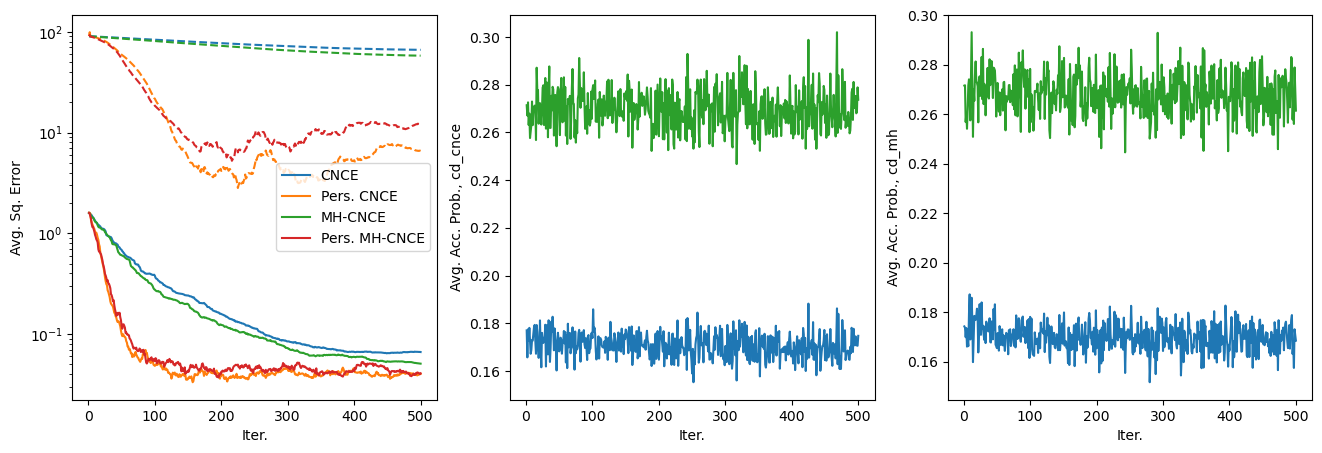

In [118]:
# Visualise results
num_samples = 200

#error_res = np.load("res/final_param_error_cnce_acceptance_prob_exp_w_pers_num_samples_" + str(num_samples) + "_test" + ".npy")
#acc_prob_res = np.load("res/final_acc_prob_cnce_acceptance_prob_exp_w_pers_num_samples_" + str(num_samples) + "_test" + ".npy")
error_res = np.load("res/final_param_error_cnce_exp_w_pers_num_samples_" + str(num_samples) + "_test.npy")
acc_prob_res = np.load("res/final_acc_prob_pers_cnce_exp_w_pers_num_samples_" + str(num_samples) + "_test.npy")
colors = ['C0', 'C1', 'C2', 'C3']
assert len(colors) >= len(configs), "Need one colour for each method"

def get_statistics(data):
    median = np.median(data, axis=-1)
    upper_quartile = np.max(data, axis=-1)
    lower_quartile = np.min(data, axis=-1)
    
    return median, upper_quartile, lower_quartile
        
def skip_list_item(lst: list, nth: int):
    """Skip every nth element in list"""
    return list(
        map(
            lambda val: val[1],
            filter(lambda idx_row: (idx_row[0] % nth == 0), enumerate(lst)),
        )
    )
    
plot_all = False
num_its = error_res.shape[-2]
x = np.arange(num_its) + 1


if num_samples == 1000:
    x = skip_list_item(x, 5)
    

labels = ['CNCE', 'Pers. CNCE', 'MH-CNCE', 'Pers. MH-CNCE']
for i, J in enumerate(num_neg_samples):
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    for j, config in enumerate(configs):
        
        if plot_all:
            for k in range(reps):
                if num_samples == 1000:
                    data = skip_list_item(error_res[i, j, :, k], 5)
                else:
                    data = error_res[i, j, :, k]
                    
                if k == 0:
                    ax[j].plot(x, data, color=colors[j], label=labels[j])
                else:
                    ax[j].plot(x, data, color=colors[j])
                    
            ax[j].legend()
            ax[j].set_ylim([-1, 100])        
            ax[j].set_xlabel("Iter.")
            ax[j].set_ylabel("Avg. Sq. Error")
            

        else:
            ax[0].set_yscale('log')
            
            if num_samples == 1000:
                err_data = skip_list_item(error_res[i, j, :, :], 5)
                cnce_data = skip_list_item(acc_prob_res[i, j, 0, :, :], 5)
                mh_cnce_data = skip_list_item(acc_prob_res[i, j, 1, :, :], 5)

            else:
                err_data = error_res[i, j, :, :]
                cnce_data = acc_prob_res[i, j, 0, :, :]
                mh_cnce_data = acc_prob_res[i, j, 1, :, :]

                
            err_median, err_upper_quartile, err_lower_quartile = get_statistics(err_data)


            ax[0].plot(x, err_median, color=colors[j], label=labels[j])
            ax[0].plot(x, err_upper_quartile, '--', color=colors[j])


            cnce_median, cnce_upper_quartile, cnce_lower_quartile = get_statistics(cnce_data)
            mh_cnce_median, mh_cnce_upper_quartile, mh_cnce_lower_quartile = get_statistics(mh_cnce_data)

        
            if j == 0:
                ax[1].plot(x, cnce_median, color=colors[0], label="CNCE")
                ax[1].plot(x, mh_cnce_median, color=colors[2], label="MH-CNCE")
                ax[1].set_xlabel("Iter.")
                ax[1].set_ylabel("Avg. Acc. Prob., " + config["label"])
            elif j == 2:
                ax[2].plot(x, cnce_median, color=colors[0], label="CNCE")
                ax[2].plot(x, mh_cnce_median, color=colors[2], label="MH-CNCE")
                ax[2].set_xlabel("Iter.")
                ax[2].set_ylabel("Avg. Acc. Prob., " + config["label"])


    ax[0].legend()            

    if plot_all:
         tikzplotlib.save("res/cnce_acc_prob_res_num_samples_" + str(num_samples) + "_num_neg_samples_" + str(J) + "_all.tex")
    else:
        ax[0].set_xlabel("Iter.")
        ax[0].set_ylabel("Avg. Sq. Error")
        
        tikzplotlib.save("res/cnce_acc_prob_res_num_samples_" + str(num_samples) + "_num_neg_samples_" + str(J) + ".tex")

    plt.show()